## Import neccessary modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
import joblib
import os
import json
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.utils import resample
import time
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,  confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

## Import data functions

In [2]:
def read_csv_to_ndarray(file_path: str) -> Tuple[np.ndarray, List[str], List[str]]:
    """
    Reads a CSV file and converts it to a NumPy array for features and a list for labels.
    """
    df = pd.read_csv(file_path)
    if df.empty:
        raise ValueError("CSV file is empty or data is invalid")
    
    feature_names = df.columns[:-1].tolist()
    features = df.iloc[:, :-1].values
    labels = df.iloc[:, -1].astype(str).tolist()
    return features, labels, feature_names

## Data Cleaning and class distribution functions

In [3]:
def encode_labels(labels: List[str]) -> Tuple[np.ndarray, Dict[str, int]]:
    """
    Encodes string labels into numeric values.
    """
    unique_labels = sorted(set(labels))
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    encoded_labels = np.array([label_map[label] for label in labels])
    return encoded_labels, label_map

def split_data(features: np.ndarray, labels: np.ndarray, test_size: float = 0.2) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Splits data into training and testing sets.
    """
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)
    return x_train, y_train, x_test, y_test

def clean_data(features: np.ndarray) -> np.ndarray:
    """
    Cleans the feature matrix by replacing invalid values with finite values.
    """
    cleaned_features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    return cleaned_features

def import_model(filepath: str) -> Tuple[DecisionTreeClassifier, Dict[str, int], List[str]]:
    """
    Imports the model and metadata using joblib.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File {filepath} not found")
    
    data = joblib.load(filepath)
    return data['model'], data['label_map'], data['selected_features']

def analyze_class_distribution(labels: List[str], title: str = "Class Distribution") -> None:
    """
    Analyzes and prints the distribution of classes in the dataset.
    """
    unique, counts = np.unique(labels, return_counts=True)
    total = len(labels)
    
    print(f"\n{title}:")
    print("-" * 40)
    for label, count in zip(unique, counts):
        percentage = (count / total) * 100
        print(f"Class '{label}': {count} samples ({percentage:.2f}%)")
    
    imbalance_ratio = max(counts) / min(counts)
    print(f"\nImbalance Ratio (majority:minority): {imbalance_ratio:.2f}:1")

def calculate_class_weights(labels: List[str]) -> Dict[str, float]:
    """
    Calculates balanced class weights inversely proportional to class frequencies.
    """
    unique, counts = np.unique(labels, return_counts=True)
    n_samples = len(labels)
    n_classes = len(unique)
    
    weights = {label: n_samples / (n_classes * count) for label, count in zip(unique, counts)}
    return weights

## Feature engineering and selection

In [4]:
def select_top_features(features: np.ndarray, labels: np.ndarray, feature_names: List[str], n_features: int = 10) -> Tuple[np.ndarray, List[str], List[int]]:
    """
    Selects top N features based on importance scores using actual labels.
    """
    # Train a preliminary model with actual labels to get feature importance
    prelim_model = DecisionTreeClassifier(max_depth=10, random_state=42)
    prelim_model.fit(features, labels)
    
    # Get indices of top N features
    importances = prelim_model.feature_importances_
    top_indices = np.argsort(importances)[::-1][:n_features]
    
    # Select top features and their names
    selected_features = features[:, top_indices]
    selected_names = [feature_names[i] for i in top_indices]
    
    print("\nTop 10 features selected:")
    for idx, (name, importance) in enumerate(zip(selected_names, importances[top_indices]), 1):
        print(f"{idx}. {name} (importance: {importance:.4f})")
    
    return selected_features, selected_names, top_indices.tolist()

def create_feature_mapping(file_paths: List[str], selected_indices: List[int]) -> Dict[str, Dict[int, str]]:
    """
    Creates a mapping of feature indices to their names for each file.
    """
    feature_mapping = {}
    
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        _, _, feature_names = read_csv_to_ndarray(file_path)
        
        file_mapping = {idx: feature_names[original_idx] 
                       for idx, original_idx in enumerate(selected_indices)}
        feature_mapping[file_name] = file_mapping
    
    return feature_mapping


## SMOTE imputing for low frequency classes and sample file exportation

In [5]:
def add_rows_with_smote(features: np.ndarray, labels: np.ndarray, n_samples: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Adds a specific number of synthetic samples to a dataset using SMOTE.
    
    Args:
        features (np.ndarray): The feature matrix
        labels (np.ndarray): The label array
        n_samples (int): The number of synthetic samples to generate
        
    Returns:
        Tuple[np.ndarray, np.ndarray]: Augmented features and labels arrays
    """
    # Get current class distribution
    unique_labels, class_counts = np.unique(labels, return_counts=True)
    n_classes = len(unique_labels)
    
    # Calculate how many samples to add per class (distribute evenly)
    samples_per_class = n_samples // n_classes
    remainder = n_samples % n_classes
    
    # Create sampling strategy dictionary
    sampling_strategy = {}
    for i, label in enumerate(unique_labels):
        # Add remainder samples to first classes if needed
        extra = 1 if i < remainder else 0
        target_count = class_counts[i] + samples_per_class + extra
        sampling_strategy[label] = target_count
    
    # Apply SMOTE with the custom sampling strategy
    smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
    X_resampled, y_resampled = smote.fit_resample(features, labels)
    
    print(f"Added {X_resampled.shape[0] - features.shape[0]} synthetic samples using SMOTE")
    print(f"Original shape: {features.shape}, New shape: {X_resampled.shape}")
    
    # Analyze the distribution before and after
    print("\nClass Distribution - Before:")
    for label, count in zip(unique_labels, class_counts):
        print(f"Class {label}: {count} samples")
    
    # Get new distribution
    new_unique, new_counts = np.unique(y_resampled, return_counts=True)
    print("\nClass Distribution - After:")
    for label, count in zip(new_unique, new_counts):
        print(f"Class {label}: {count} samples")
    
    return X_resampled, y_resampled

def balance_classes_equal_samples(features: np.ndarray, labels: np.ndarray, n_samples_per_class: int = 20) -> Tuple[np.ndarray, np.ndarray]:
    """
    Balances the dataset by downsampling each class to have an equal number of samples (n_samples_per_class),
    and shuffles the resulting dataset.
    """
    unique_labels = np.unique(labels)
    balanced_features = []
    balanced_labels = []
    
    for label in unique_labels:
        # Get all the indices for the current label
        class_indices = np.where(labels == label)[0]
        
        # Downsample to have n_samples_per_class for each class
        sampled_indices = resample(class_indices, n_samples=n_samples_per_class, random_state=42)
        
        balanced_features.append(features[sampled_indices])
        balanced_labels.append(labels[sampled_indices])
    
    # Concatenate all the balanced data
    balanced_features = np.vstack(balanced_features)
    balanced_labels = np.concatenate(balanced_labels)
    
    # Shuffle the dataset
    shuffle_indices = np.random.permutation(balanced_features.shape[0])
    balanced_features = balanced_features[shuffle_indices]
    balanced_labels = balanced_labels[shuffle_indices]
    
    return balanced_features, balanced_labels


## Export functions

In [6]:
def export_model(model: DecisionTreeClassifier, label_map: Dict[str, int], selected_features: List[str], filepath: str) -> None:
    """
    Exports the model and metadata using joblib.
    """
    export_data = {
        'model': model, 
        'label_map': label_map,
        'selected_features': selected_features
    }
    joblib.dump(export_data, filepath)
    print(f"Model and metadata exported to {filepath}")

def export_feature_mapping(mapping: Dict[str, Dict[int, str]], filepath: str) -> None:
    """
    Exports the feature mapping to a JSON file.
    """
    with open(filepath, 'w') as f:
        json.dump(mapping, f, indent=2)
    print(f"Feature mapping exported to {filepath}")

def export_class_labels_json(label_map: Dict[str, int], filepath: str) -> None:
    """
    Exports the class label mapping (from label to numeric encoding) to a JSON file.
    """
    with open(filepath, 'w') as f:
        json.dump(label_map, f, indent=2)
    print(f"Class labels exported to {filepath}")


## Analysis functions

In [7]:
def print_classification_metrics(y_true: np.ndarray, y_pred: np.ndarray, label_map: Dict[str, int]) -> None:
    """
    Prints detailed classification metrics including precision, recall, and F1-score.
    """
    # Inverse label mapping for readable class names
    inv_label_map = {v: k for k, v in label_map.items()}
    
    # Get classification report
    report = classification_report(y_true, y_pred, target_names=[inv_label_map[i] for i in sorted(inv_label_map.keys())])
    
    print("\nDetailed Classification Metrics:")
    print("-" * 40)
    print(report)
    
    # Calculate per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    
    print("\nPer-class Performance:")
    print("-" * 40)
    for i in range(len(precision)):
        class_name = inv_label_map[i]
        print(f"Class '{class_name}':")
        print(f"- Precision: {precision[i]:.4f}")
        print(f"- Recall: {recall[i]:.4f}")
        print(f"- F1-score: {f1[i]:.4f}")
        print(f"- Support: {support[i]}")


def perform_cross_validation(features: np.ndarray, labels: np.ndarray, n_splits: int = 5) -> None:
    """
    Performs stratified k-fold cross-validation and prints results.
    """
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    model = DecisionTreeClassifier(max_depth=10, random_state=42)
    
    scores = cross_val_score(model, features, labels, cv=cv, scoring='accuracy')
    
    print(f"\nCross-validation Results ({n_splits}-fold):")
    print("-" * 40)
    print(f"Mean Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    print(f"Individual Fold Scores: {', '.join(f'{score:.4f}' for score in scores)}")

def analyze_feature_correlations(features: np.ndarray, feature_names: List[str], labels: np.ndarray) -> None:
    """
    Analyzes and plots feature correlations to check for potential data leakage.
    """
    # Create DataFrame with features and labels
    df = pd.DataFrame(features, columns=feature_names)
    df['label'] = labels
    
    # Calculate correlations
    correlations = df.corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('feature_correlations.png')
    plt.close()
    
    # Check for high correlations with label
    label_correlations = correlations['label'].abs().sort_values(ascending=False)[1:]  # Exclude self-correlation
    print("\nFeature-Label Correlations:")
    print("-" * 40)
    for feature, corr in label_correlations.items():
        print(f"{feature}: {corr:.4f}")
    
    # Warning for potential data leakage
    high_corr_features = label_correlations[label_correlations > 0.9]
    if not high_corr_features.empty:
        print("\nWARNING: Potential data leakage detected!")
        print("The following features have very high correlation (>0.9) with the label:")
        for feature, corr in high_corr_features.items():
            print(f"- {feature}: {corr:.4f}")


## Save analysis charts

In [8]:
def save_feature_importance_chart(model: DecisionTreeClassifier, feature_names: List[str], filepath: str):
    """
    Saves a bar chart of feature importances.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances (Top 5 Features)")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.savefig(filepath)
    plt.close()
    print(f"Feature importance chart saved to {filepath}")

def save_confusion_matrix(y_test: np.ndarray, predictions: np.ndarray, filepath: str):
    """
    Saves a confusion matrix chart.
    """
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(filepath)
    plt.close()
    print(f"Confusion matrix saved to {filepath}")



## Run Model Comparison

In [9]:
class ModelComparison:
    """
    Class to compare different ML models on the same pipeline
    """
    
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.results = []
        self.models = self._initialize_models()
        
    def _initialize_models(self):
        """Initialize different models to test"""
        return {
            'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
            'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
            'Naive Bayes': GaussianNB(),
            'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
            'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
        }
    
    def load_and_prepare_data(self, read_csv_to_ndarray, clean_data, encode_labels, 
                              add_rows_with_smote, select_top_features):
        """Load and prepare data using existing pipeline"""
        print("="*80)
        print("LOADING AND PREPARING DATA")
        print("="*80)
        
        all_features = []
        all_labels = []
        all_feature_names = []

        print("\nReading data from CSV...")
        for file_path in self.file_paths:
            features, labels, feature_names = read_csv_to_ndarray(file_path)
            all_features.append(features)
            all_labels.extend(labels)
            if not all_feature_names:
                all_feature_names = feature_names

        features = np.vstack(all_features)

        print("Cleaning data...")
        features = clean_data(features)

        print("Encoding labels...")
        encoded_labels, label_map = encode_labels(all_labels)

        # Add synthetic samples using SMOTE
        print("Adding synthetic samples for Bot and Infiltration classes...")
        target_classes = [1, 3]
        target_mask = np.isin(encoded_labels, target_classes)
        target_features = features[target_mask]
        target_labels = encoded_labels[target_mask]

        synthetic_features, synthetic_labels = add_rows_with_smote(
            target_features, target_labels, n_samples=100000
        )

        original_count = len(target_labels)
        new_samples_features = synthetic_features[original_count:]
        new_samples_labels = synthetic_labels[original_count:]

        features = np.vstack([features, new_samples_features])
        encoded_labels = np.concatenate([encoded_labels, new_samples_labels])

        print("Selecting top 10 features...")
        selected_features, selected_names, selected_indices = select_top_features(
            features, encoded_labels, all_feature_names
        )

        return selected_features, encoded_labels, label_map, selected_names
    
    def train_and_evaluate_model(self, model_name, model, x_train, y_train, x_test, y_test, label_map):
        """Train a model and collect performance metrics"""
        print(f"\n{'='*80}")
        print(f"TESTING MODEL: {model_name}")
        print(f"{'='*80}")
        
        result = {
            'model_name': model_name,
            'model_type': type(model).__name__
        }
        
        # Training
        print("Training...")
        train_start = time.time()
        model.fit(x_train, y_train)
        train_time = time.time() - train_start
        result['train_time'] = train_time
        print(f"Training completed in {train_time:.2f} seconds")
        
        # Prediction
        print("Making predictions...")
        pred_start = time.time()
        predictions = model.predict(x_test)
        pred_time = time.time() - pred_start
        result['prediction_time'] = pred_time
        print(f"Prediction completed in {pred_time:.2f} seconds")
        
        # Calculate metrics
        result['accuracy'] = accuracy_score(y_test, predictions)
        result['precision_macro'] = precision_score(y_test, predictions, average='macro', zero_division=0)
        result['recall_macro'] = recall_score(y_test, predictions, average='macro', zero_division=0)
        result['f1_macro'] = f1_score(y_test, predictions, average='macro', zero_division=0)
        result['precision_weighted'] = precision_score(y_test, predictions, average='weighted', zero_division=0)
        result['recall_weighted'] = recall_score(y_test, predictions, average='weighted', zero_division=0)
        result['f1_weighted'] = f1_score(y_test, predictions, average='weighted', zero_division=0)
        
        # Print summary
        print(f"\nResults:")
        print(f"  accuracy: {result['accuracy']:.4f}")
        print(f"  F1-Score (Macro): {result['f1_macro']:.4f}")
        print(f"  F1-Score (Weighted): {result['f1_weighted']:.4f}")
        print(f"  Training Time: {train_time:.2f}s")
        print(f"  Prediction Time: {pred_time:.2f}s")
        
        return result, predictions
    
    def run_comparison(self, read_csv_to_ndarray, clean_data, encode_labels, 
                       add_rows_with_smote, select_top_features, split_data):
        """Run the complete comparison across all models"""
        
        # Load and prepare data
        selected_features, encoded_labels, label_map, selected_names = self.load_and_prepare_data(
            read_csv_to_ndarray, clean_data, encode_labels, 
            add_rows_with_smote, select_top_features
        )
        
        # Split data
        print("\n" + "="*80)
        print("SPLITTING DATA")
        print("="*80)
        x_train, y_train, x_test, y_test = split_data(selected_features, encoded_labels)
        print(f"Training samples: {len(x_train)}")
        print(f"Testing samples: {len(x_test)}")
        
        # Test each model
        for model_name, model in self.models.items():
            try:
                result, predictions = self.train_and_evaluate_model(
                    model_name, model, x_train, y_train, x_test, y_test, label_map
                )
                self.results.append(result)
            except Exception as e:
                print(f"\nError training {model_name}: {str(e)}")
                continue
        
        return self.results, label_map
    
    def generate_comparison_report(self, output_file='model_comparison_report.txt'):
        """Generate a detailed comparison report"""
        print("\n" + "="*80)
        print("FINAL COMPARISON REPORT")
        print("="*80)
        
        # Sort by accuracy
        sorted_results = sorted(self.results, key=lambda x: x['accuracy'], reverse=True)
        
        report_lines = []
        report_lines.append("="*80)
        report_lines.append("MODEL COMPARISON REPORT")
        report_lines.append("="*80)
        report_lines.append("")
        
        # Summary table
        report_lines.append("PERFORMANCE SUMMARY (Sorted by accuracy)")
        report_lines.append("-"*80)
        header = f"{'Rank':<6}{'Model':<25}{'accuracy':<12}{'F1-Macro':<12}{'Train Time':<12}{'Pred Time':<12}"
        report_lines.append(header)
        report_lines.append("-"*80)
        
        for i, result in enumerate(sorted_results, 1):
            line = (f"{i:<6}"
                   f"{result['model_name']:<25}"
                   f"{result['accuracy']:.4f}{'':<6}"
                   f"{result['f1_macro']:.4f}{'':<6}"
                   f"{result['train_time']:.2f}s{'':<6}"
                   f"{result['prediction_time']:.2f}s")
            report_lines.append(line)
        
        report_lines.append("")
        report_lines.append("="*80)
        report_lines.append("DETAILED METRICS")
        report_lines.append("="*80)
        
        for i, result in enumerate(sorted_results, 1):
            report_lines.append(f"\n{i}. {result['model_name']}")
            report_lines.append("-"*40)
            report_lines.append(f"   Model Type: {result['model_type']}")
            report_lines.append(f"   accuracy: {result['accuracy']:.4f}")
            report_lines.append(f"   Precision (Macro): {result['precision_macro']:.4f}")
            report_lines.append(f"   Recall (Macro): {result['recall_macro']:.4f}")
            report_lines.append(f"   F1-Score (Macro): {result['f1_macro']:.4f}")
            report_lines.append(f"   Precision (Weighted): {result['precision_weighted']:.4f}")
            report_lines.append(f"   Recall (Weighted): {result['recall_weighted']:.4f}")
            report_lines.append(f"   F1-Score (Weighted): {result['f1_weighted']:.4f}")
            report_lines.append(f"   Training Time: {result['train_time']:.2f} seconds")
            report_lines.append(f"   Prediction Time: {result['prediction_time']:.2f} seconds")
        
        # Best models analysis
        report_lines.append("\n" + "="*80)
        report_lines.append("BEST MODELS BY CATEGORY")
        report_lines.append("="*80)
        
        best_accuracy = max(sorted_results, key=lambda x: x['accuracy'])
        best_f1 = max(sorted_results, key=lambda x: x['f1_macro'])
        fastest_train = min(sorted_results, key=lambda x: x['train_time'])
        fastest_pred = min(sorted_results, key=lambda x: x['prediction_time'])
        
        report_lines.append(f"\nBest accuracy: {best_accuracy['model_name']} ({best_accuracy['accuracy']:.4f})")
        report_lines.append(f"Best F1-Score: {best_f1['model_name']} ({best_f1['f1_macro']:.4f})")
        report_lines.append(f"Fastest Training: {fastest_train['model_name']} ({fastest_train['train_time']:.2f}s)")
        report_lines.append(f"Fastest Prediction: {fastest_pred['model_name']} ({fastest_pred['prediction_time']:.2f}s)")
        
        # Print to console
        report_text = "\n".join(report_lines)
        print(report_text)
        
        # Save to file
        with open(output_file, 'w') as f:
            f.write(report_text)
        print(f"\nReport saved to: {output_file}")
        
        return report_text
    
    def save_results_json(self, output_file='model_comparison_results.json'):
        """Save results as JSON"""
        with open(output_file, 'w') as f:
            json.dump(self.results, f, indent=2)
        print(f"Results saved to: {output_file}")
    
    def save_results_csv(self, output_file='model_comparison_results.csv'):
        """Save results as CSV"""
        df = pd.DataFrame(self.results)
        df = df.sort_values('accuracy', ascending=False)
        df.to_csv(output_file, index=False)
        print(f"Results saved to: {output_file}")


# Example usage
if __name__ == "__main__":
    # Define file paths
    file_paths = [
        "./data/1.csv",
        "./data/2.csv",
        "./data/3.csv",
        "./data/4.csv"
    ]
    
    # Create comparison instance
    comparison = ModelComparison(file_paths)
    
    # Run comparison
    results, label_map = comparison.run_comparison(
        read_csv_to_ndarray,
        clean_data,
        encode_labels,
        add_rows_with_smote,
        select_top_features,
        split_data
    )
    
    # Generate reports
    comparison.generate_comparison_report('model_comparison_report.txt')
    comparison.save_results_json('model_comparison_results.json')
    comparison.save_results_csv('model_comparison_results.csv')

LOADING AND PREPARING DATA

Reading data from CSV...
Cleaning data...
Encoding labels...
Adding synthetic samples for Bot and Infiltration classes...
Added 100000 synthetic samples using SMOTE
Original shape: (2002, 78), New shape: (102002, 78)

Class Distribution - Before:
Class 1: 1966 samples
Class 3: 36 samples

Class Distribution - After:
Class 1: 51966 samples
Class 3: 50036 samples
Selecting top 10 features...

Top 10 features selected:
1. Total Length of Fwd Packets (importance: 0.2311)
2. Flow Bytes/s (importance: 0.1966)
3.  Bwd Packet Length Std (importance: 0.1963)
4.  Active Min (importance: 0.0750)
5.  Subflow Bwd Packets (importance: 0.0641)
6.  Destination Port (importance: 0.0544)
7.  Init_Win_bytes_backward (importance: 0.0528)
8. Init_Win_bytes_forward (importance: 0.0347)
9.  Packet Length Mean (importance: 0.0321)
10.  Min Packet Length (importance: 0.0286)

SPLITTING DATA
Training samples: 873477
Testing samples: 218370

TESTING MODEL: Decision Tree
Training...
Tr

## Comparison visualization

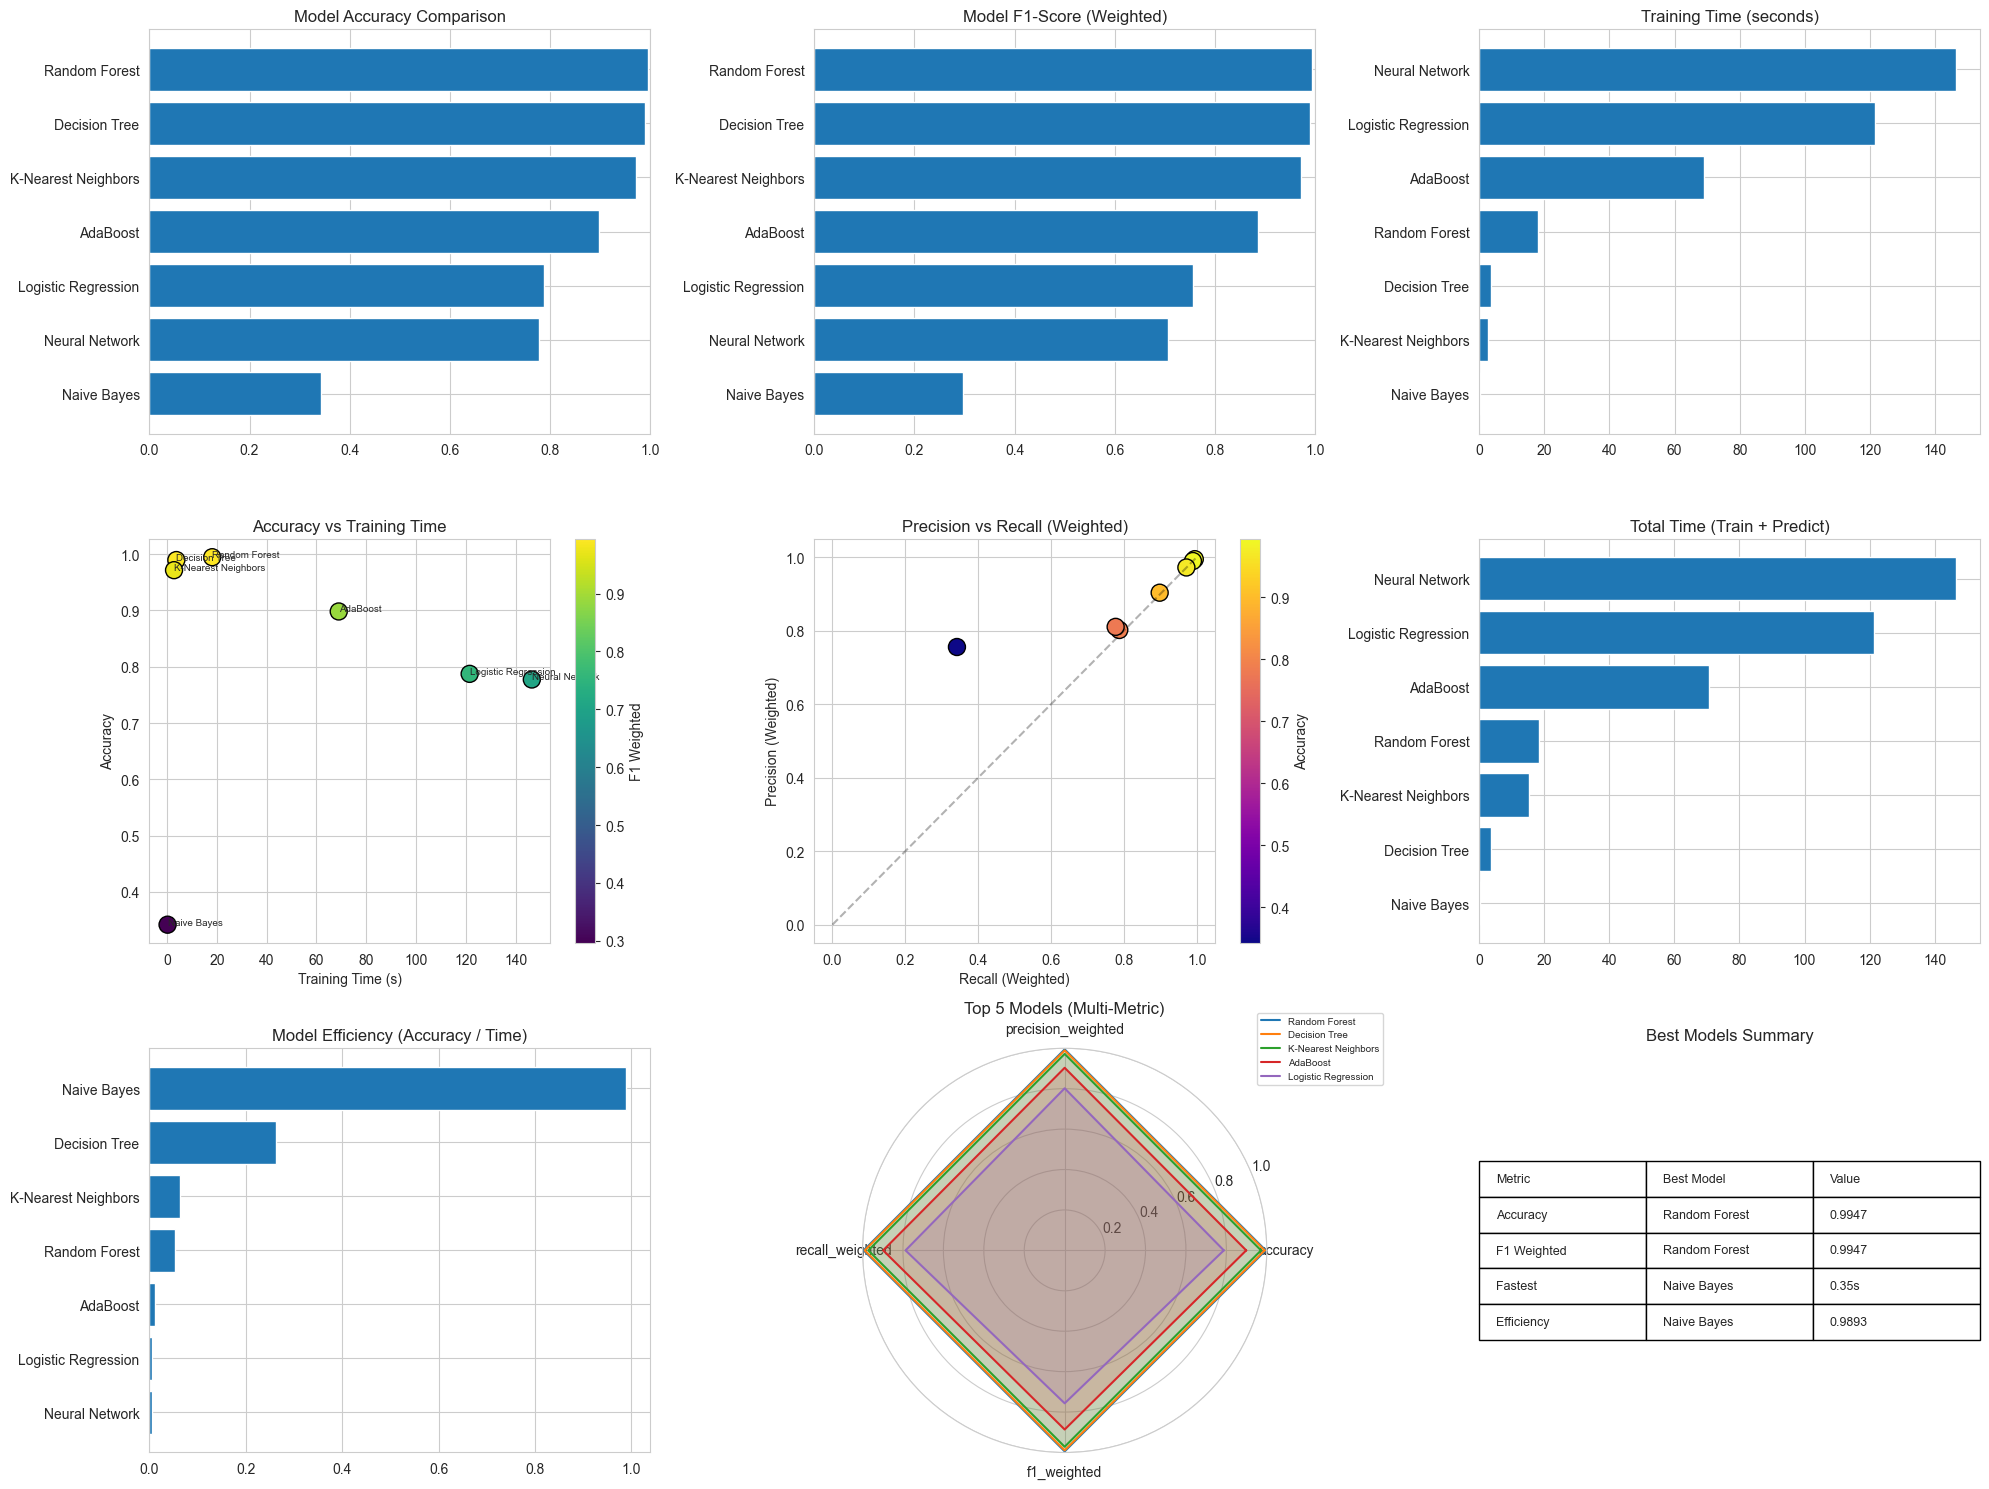

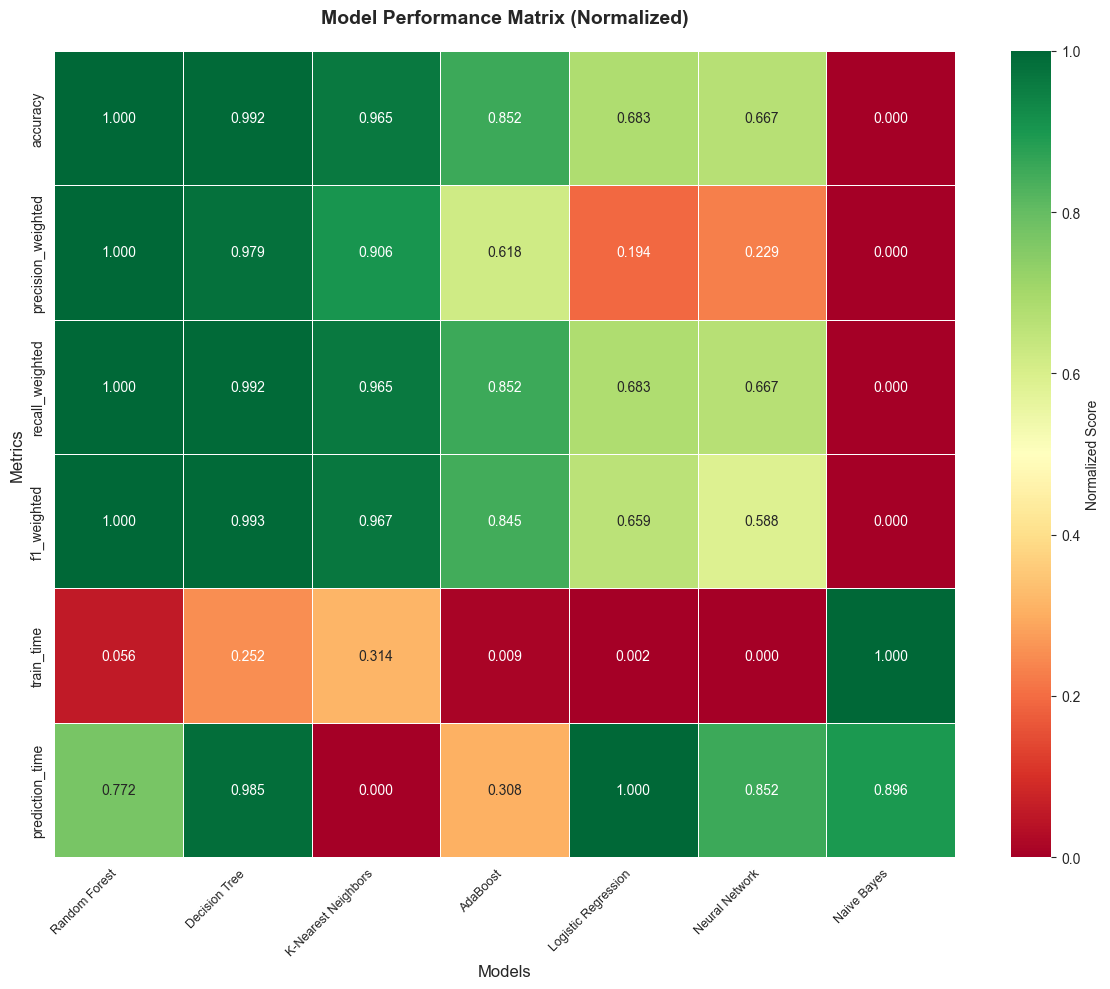

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def create_comparison_visualizations(csv_file='model_comparison_results.csv'):
    """
    Create comprehensive visualizations from model comparison results
    """

    df = pd.read_csv(csv_file)

    # Derived columns
    df['total_time'] = df['train_time'] + df['prediction_time']
    df['efficiency_score'] = df['accuracy'] / (df['total_time'] + 1e-6)

    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (16, 12)

    fig = plt.figure(figsize=(20, 15))

    # 1. Accuracy Comparison
    ax1 = plt.subplot(3, 3, 1)
    df_sorted = df.sort_values('accuracy')
    ax1.barh(df_sorted['model_name'], df_sorted['accuracy'])
    ax1.set_xlim(0, 1)
    ax1.set_title('Model Accuracy Comparison')

    # 2. F1 Weighted Comparison
    ax2 = plt.subplot(3, 3, 2)
    df_sorted = df.sort_values('f1_weighted')
    ax2.barh(df_sorted['model_name'], df_sorted['f1_weighted'])
    ax2.set_xlim(0, 1)
    ax2.set_title('Model F1-Score (Weighted)')

    # 3. Training Time
    ax3 = plt.subplot(3, 3, 3)
    df_sorted = df.sort_values('train_time')
    ax3.barh(df_sorted['model_name'], df_sorted['train_time'])
    ax3.set_title('Training Time (seconds)')

    # 4. Accuracy vs Training Time
    ax4 = plt.subplot(3, 3, 4)
    scatter = ax4.scatter(
        df['train_time'],
        df['accuracy'],
        c=df['f1_weighted'],
        s=150,
        cmap='viridis',
        edgecolors='black'
    )
    ax4.set_xlabel('Training Time (s)')
    ax4.set_ylabel('Accuracy')
    ax4.set_title('Accuracy vs Training Time')
    plt.colorbar(scatter, ax=ax4, label='F1 Weighted')

    # Annotate
    for _, row in df.iterrows():
        ax4.annotate(
            row['model_name'][:20],
            (row['train_time'], row['accuracy']),
            fontsize=7
        )

    # 5. Precision vs Recall (Weighted)
    ax5 = plt.subplot(3, 3, 5)
    scatter2 = ax5.scatter(
        df['recall_weighted'],
        df['precision_weighted'],
        c=df['accuracy'],
        s=150,
        cmap='plasma',
        edgecolors='black'
    )
    ax5.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax5.set_xlabel('Recall (Weighted)')
    ax5.set_ylabel('Precision (Weighted)')
    ax5.set_title('Precision vs Recall (Weighted)')
    plt.colorbar(scatter2, ax=ax5, label='Accuracy')

    # 6. Total Time
    ax6 = plt.subplot(3, 3, 6)
    df_sorted = df.sort_values('total_time')
    ax6.barh(df_sorted['model_name'], df_sorted['total_time'])
    ax6.set_title('Total Time (Train + Predict)')

    # 7. Efficiency Score
    ax7 = plt.subplot(3, 3, 7)
    df_sorted = df.sort_values('efficiency_score')
    ax7.barh(df_sorted['model_name'], df_sorted['efficiency_score'])
    ax7.set_title('Model Efficiency (Accuracy / Time)')

    # 8. Radar Chart (Top 5 Accuracy)
    ax8 = plt.subplot(3, 3, 8, polar=True)
    top_5 = df.nlargest(5, 'accuracy')

    categories = [
        'accuracy',
        'precision_weighted',
        'recall_weighted',
        'f1_weighted'
    ]

    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]

    for _, row in top_5.iterrows():
        values = [row[c] for c in categories]
        values += values[:1]

        ax8.plot(angles, values, label=row['model_name'])
        ax8.fill(angles, values, alpha=0.15)

    ax8.set_xticks(angles[:-1])
    ax8.set_xticklabels(categories)
    ax8.set_ylim(0, 1)
    ax8.set_title('Top 5 Models (Multi-Metric)')
    ax8.legend(fontsize=7, loc='upper right', bbox_to_anchor=(1.3, 1.1))

    # 9. Summary Table
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    best_acc = df.loc[df['accuracy'].idxmax()]
    best_f1 = df.loc[df['f1_weighted'].idxmax()]
    fastest = df.loc[df['total_time'].idxmin()]
    most_eff = df.loc[df['efficiency_score'].idxmax()]

    table_data = [
        ['Metric', 'Best Model', 'Value'],
        ['Accuracy', best_acc['model_name'], f"{best_acc['accuracy']:.4f}"],
        ['F1 Weighted', best_f1['model_name'], f"{best_f1['f1_weighted']:.4f}"],
        ['Fastest', fastest['model_name'], f"{fastest['total_time']:.2f}s"],
        ['Efficiency', most_eff['model_name'], f"{most_eff['efficiency_score']:.4f}"],
    ]

    table = ax9.table(cellText=table_data, loc='center', cellLoc='left')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.8)

    ax9.set_title('Best Models Summary')

    plt.tight_layout()
    plt.savefig('model_comparison_visualization.png', dpi=300)
    plt.show()


def create_performance_matrix(csv_file='model_comparison_results.csv'):
    """
    Create a normalized performance heatmap from model comparison results

    Expected CSV columns:
    model_name, model_type, train_time, prediction_time,
    accuracy, precision_macro, recall_macro, f1_macro,
    precision_weighted, recall_weighted, f1_weighted
    """

    df = pd.read_csv(csv_file)

    # Metrics to visualize
    metrics = [
        'accuracy',
        'precision_weighted',
        'recall_weighted',
        'f1_weighted',
        'train_time',
        'prediction_time'
    ]

    # Prepare data
    matrix = df[metrics].copy()

    # Invert time metrics (lower is better)
    matrix['train_time'] = 1 / (matrix['train_time'] + 1)
    matrix['prediction_time'] = 1 / (matrix['prediction_time'] + 1)

    # Normalize all metrics to 0–1
    matrix = (matrix - matrix.min()) / (matrix.max() - matrix.min())

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        matrix.T,
        annot=True,
        fmt=".3f",
        cmap="RdYlGn",
        linewidths=0.5,
        xticklabels=df['model_name'],
        yticklabels=metrics,
        cbar_kws={'label': 'Normalized Score'}
    )

    plt.title('Model Performance Matrix (Normalized)', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Metrics', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.savefig('model_performance_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()


create_comparison_visualizations('model_comparison_results.csv') 
create_performance_matrix('model_comparison_results.csv')


In [11]:
file_paths = [
    "./data/1.csv",
    "./data/2.csv",
    "./data/3.csv",
    "./data/4.csv"
]

all_features = []
all_labels = []
all_feature_names = []

print("Reading data from CSV...")
for file_path in file_paths:
    features, labels, feature_names = read_csv_to_ndarray(file_path)
    all_features.append(features)
    all_labels.extend(labels)
    if not all_feature_names:
        all_feature_names = feature_names

features = np.vstack(all_features)

# Analyze class distribution
print("\nAnalyzing class distribution...")
analyze_class_distribution(all_labels)

print("\nCleaning data...")
features = clean_data(features)

print("Encoding labels...")
encoded_labels, label_map = encode_labels(all_labels)

# Add synthetic samples using SMOTE only for Bot and Infiltration classes
print("\nAdding synthetic samples for Bot and Infiltration classes...")

# 1. Extract only Bot (1) and Infiltration (3) samples
target_classes = [1, 3]  # Bot and Infiltration
target_mask = np.isin(encoded_labels, target_classes)
target_features = features[target_mask]
target_labels = encoded_labels[target_mask]

# 2. Generate synthetic samples for just these classes
synthetic_features, synthetic_labels = add_rows_with_smote(
    target_features, target_labels, n_samples=100000
)

# 3. Get only the newly generated samples
original_count = len(target_labels)
new_samples_features = synthetic_features[original_count:]
new_samples_labels = synthetic_labels[original_count:]

# 4. Add them back to the original dataset
features = np.vstack([features, new_samples_features])
encoded_labels = np.concatenate([encoded_labels, new_samples_labels])

# Display final distribution
unique_final, counts_final = np.unique(encoded_labels, return_counts=True)
class_names = {v: k for k, v in label_map.items()}
print("\nFinal distribution after adding synthetic samples:")
for label, count in zip(unique_final, counts_final):
    print(f"{class_names.get(label, f'Class {label}')}: {count} samples")

export_class_labels_json(label_map, "class_labels.json")

print("\nSelecting top 10 features...")
selected_features, selected_names, selected_indices = select_top_features(
    features, encoded_labels, all_feature_names
)

# Balance dataset by equal sampling and shuffle
print("\nBalancing dataset by equal sampling of each class and shuffling...")
balanced_features, balanced_labels = balance_classes_equal_samples(features, encoded_labels, n_samples_per_class=20)

# Save balanced and shuffled dataset to CSV
balanced_df = pd.DataFrame(balanced_features, columns=all_feature_names)
balanced_df['label'] = balanced_labels
balanced_df.to_csv("balanced_shuffled_dataset.csv", index=False)
print("Balanced and shuffled dataset saved to 'balanced_shuffled_dataset.csv'")

# Perform cross-validation
print("\nPerforming cross-validation...")
perform_cross_validation(selected_features, encoded_labels)

# Analyze feature correlations
print("\nAnalyzing feature correlations...")
analyze_feature_correlations(selected_features, selected_names, encoded_labels)

# Create and export feature mapping
feature_mapping = create_feature_mapping(file_paths, selected_indices)
export_feature_mapping(feature_mapping, "feature_mapping.json")

# Split data and train final model
print("\nSplitting data...")
x_train, y_train, x_test, y_test = split_data(selected_features, encoded_labels)

print("Training final model...")
model = DecisionTreeClassifier(max_depth=10, random_state=42)
model.fit(x_train, y_train)

print("Making predictions...")
predictions = model.predict(x_test)

# Print detailed classification metrics
print_classification_metrics(y_test, predictions, label_map)

accuracy = accuracy_score(y_test, predictions)
print(f"\nFinal Model Accuracy: {accuracy:.2%}")

export_model(model, label_map, selected_names, "decision_tree_model.pkl")

# Save feature importance chart using selected feature names
save_feature_importance_chart(model, selected_names, filepath="feature_importance.png")

# Save confusion matrix
save_confusion_matrix(y_test, predictions, filepath="confusion_matrix.png")

Reading data from CSV...

Analyzing class distribution...

Class Distribution:
----------------------------------------
Class 'BENIGN': 702888 samples (70.87%)
Class 'Bot': 1966 samples (0.20%)
Class 'DDoS': 128027 samples (12.91%)
Class 'Infiltration': 36 samples (0.00%)
Class 'PortScan': 158930 samples (16.02%)

Imbalance Ratio (majority:minority): 19524.67:1

Cleaning data...
Encoding labels...

Adding synthetic samples for Bot and Infiltration classes...
Added 100000 synthetic samples using SMOTE
Original shape: (2002, 78), New shape: (102002, 78)

Class Distribution - Before:
Class 1: 1966 samples
Class 3: 36 samples

Class Distribution - After:
Class 1: 51966 samples
Class 3: 50036 samples

Final distribution after adding synthetic samples:
BENIGN: 702888 samples
Bot: 51966 samples
DDoS: 128027 samples
Infiltration: 50036 samples
PortScan: 158930 samples
Class labels exported to class_labels.json

Selecting top 10 features...

Top 10 features selected:
1. Total Length of Fwd Pack